In [1]:
import os
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import glob
import sys
sys.path.append('../../../py/')

import h5py
from cosmoSim import cosmoSim
from scipy.interpolate import interp1d

In [2]:
FONT_SIZE = 14

matplotlib.rc('xtick', labelsize=FONT_SIZE)
matplotlib.rc('ytick', labelsize=FONT_SIZE)
matplotlib.rcParams['font.size']=FONT_SIZE

matplotlib.rcParams['font.family'] = 'serif'
matplotlib.rc('text', usetex=True)

ALPHA=0.3

UNIT_HEIGHT = 5

FIG_HEIGHT = UNIT_HEIGHT
FIG_WIDTH = 4 * UNIT_HEIGHT

FIGSIZE=[FIG_WIDTH,FIG_HEIGHT]
DPI=300

snap_range = [5, 4, 3, 2]

zz_color = 'b'
m2m2_color = 'g'
cdm_color = 'r'
zz_dm_color = 'tab:cyan'
m2m2_dm_color = 'tab:olive'
cdm_dm_color = 'tab:pink'

In [3]:
outpath = '../../../plots/plots_L3N256/grid/'
base_path="../../../data_prods/"
data_dir = '/home/ryan/Data'
try:
    os.mkdir(outpath)
except:
    print(f'{outpath} already exists!')


# CDM_runs = ['run_CDM_L3N256_HY']

# CDM_DM_runs = [ f'run_CDM_L3N256_DM_dir_{i}' for i in range(10) ] + ['run_CDM_L3N256_DM']

# tcDM_runs1 = [ f'run_2cDM_L3N256_HY_power00_sigma1_dir_{i}' for i in range(10) ] + ['run_2cDM_L3N256_HY_power00_sigma1']

# tcDM_DM_runs1 = [ f'run_2cDM_L3N256_DM_power00_sigma1_dir_{i}' for i in range(10) ] + ['run_2cDM_L3N256_DM_power00_sigma1']

#tcDM_runs2 = ['run_2cDM_L3N256_HY_powerm2m2_sigma1']

#tcDM_DM_runs2 = [ f'run_2cDM_L3N256_DM_powerm2m2_sigma1_dir_{i}' for i in range(10) ]


CDM_runs = [ f'run_CDM_L3N256_HY_dir_{i}' for i in range(10) ] + ['run_CDM_L3N256_HY']

#CDM_DM_runs = [ f'run_CDM_L3N256_DM_dir_{i}' for i in range(10) ] + ['run_CDM_L3N256_DM']

tcDM_runs1 = [ f'run_2cDM_L3N256_HY_power00_sigma1_dir_{i}' for i in range(10) ] + ['run_2cDM_L3N256_HY_power00_sigma1']

#tcDM_DM_runs1 = [ f'run_2cDM_L3N256_DM_power00_sigma1_dir_{i}' for i in range(10) ] + ['run_2cDM_L3N256_DM_power00_sigma1']

tcDM_runs2 = [ f'run_2cDM_L3N256_HY_powerm2m2_sigma1_dir_{i}' for i in range(10) ] + ['run_2cDM_L3N256_HY_powerm2m2_sigma1']

#tcDM_DM_runs2 = [ f'run_2cDM_L3N256_DM_powerm2m2_sigma1_dir_{i}' for i in range(10) ]

../../../plots/plots_L3N256/grid/ already exists!


In [4]:
def get_samples(domain, interpf_list):
    return [ interpf(domain) for interpf in interpf_list ]

def get_dk_averages(run_list, redshift):
    run = cosmoSim(run_list[0], base_path=base_path)
    lims, pk_interp, dk_interp, k_ny =  run.interp_combined_power_spectra(redshift)
    inf = lims[0]
    sup = lims[1]

    interps = []

    for run_n in run_list:
        run = cosmoSim(run_n, base_path=base_path)
        lims, pk_interp, interp, k_ny =  run.interp_combined_power_spectra(redshift)
        interps.append(interp)
        if lims[0] > inf: inf = lims[0]
        if lims[1] < sup: sup = lims[1]

    return (inf, sup), interps

def get_SFR_avgerages(run_list, redshift):
    run = cosmoSim(run_list[0], base_path=base_path)

    idx = run.redshift_to_index(redshift)

    fof = os.path.join(data_dir, run_list[0], f'fof_subhalo_tab_{idx:03}.hdf5')
    with h5py.File(fof, 'r') as f:
        hmass = f['Subhalo/SubhaloMassType'][()][:,4] * 10**10
        nonzero = hmass[ hmass != 0 ]
        SFR = f['Subhalo/SubhaloSFR'][()][ hmass != 0 ]
    inf = np.amin(nonzero)
    sup = np.amax(nonzero)
    
    interps = []
    
    for run_n in run_list:
        
        run = cosmoSim(run_n, base_path=base_path)
        idx = run.redshift_to_index(redshift)

        fof = os.path.join(data_dir, run_list[0], f'fof_subhalo_tab_{idx:03}.hdf5')
        with h5py.File(fof, 'r') as f:
            hmass = f['Subhalo/SubhaloMassType'][()][:,4] * 10**10
            nonzero = hmass[ hmass != 0 ]
            SFR = f['Subhalo/SubhaloSFR'][()][ hmass != 0 ]

        lims = [np.amin(nonzero), np.amax(nonzero)]
        
        if lims[0] > inf: inf = lims[0]
        if lims[1] < sup: sup = lims[1]
        
        interps.append(interp1d(nonzero, SFR))
    
    return (inf, sup), interps

def calculate_averages(domain, interps):
    samps = get_samples(domain, interps)
    avg = np.mean(samps, axis=0)
    ten = np.percentile(samps, 10, axis=0)
    ninety = np.percentile(samps, 90, axis=0)

    return avg, ten, ninety

def calculate_ratios(domain, interps_numerator, interps_denominator):
    samps_numerator = get_samples(domain, interps_numerator)
    samps_denominator = get_samples(domain, interps_denominator)

    samps = [ num / den for num, den in zip(samps_numerator, samps_denominator) ]
    avg = np.mean(samps, axis=0)
    ten = np.percentile(samps, 10, axis=0)
    ninety = np.percentile(samps, 90, axis=0)

    return avg, ten, ninety


def get_averages(CDM_runs, tcDM_runs, redshift, function='dk', ratios=False):

    if function == 'dk':
        get_avg_func = get_dk_averages
    elif function == 'SFR':
        get_avg_func = get_SFR_avgerages

    clims, CDM_interps = get_avg_func(CDM_runs, redshift)
    tlims, tcDM_interps = get_avg_func(tcDM_runs, redshift)

    inf = clims[0] if clims[0] > tlims[0] else tlims[0]
    sup = clims[1] if clims[1] < tlims[1] else tlims[1]

    domain = np.geomspace(inf, sup, num=10000)

    if ratios:
        ratio_samps, ratios_ten, ratios_ninety = calculate_ratios(domain, tcDM_interps, CDM_interps)
        return domain, (ratio_samps, ratios_ten, ratios_ninety)
    else:
        CDM_avg, CDM_ten, CDM_ninety = calculate_averages(domain, CDM_interps)
        tcDM_avg, tcDM_ten, tcDM_ninety = calculate_averages(domain, tcDM_interps)

        return domain, (CDM_avg, CDM_ten, CDM_ninety), (tcDM_avg, tcDM_ten, tcDM_ninety)

<>:35: SyntaxWarning: invalid escape sequence '\d'
<>:35: SyntaxWarning: invalid escape sequence '\d'
/tmp/ipykernel_2438951/13194686.py:35: SyntaxWarning: invalid escape sequence '\d'
  ax[0].set_ylabel("$\dot{M_{\\star}}$ [$M_{\odot}$ yr$^{-1}$]")
/home/ryan/projects/Medvedev/dm_sims/jupyter/global/paperI/../../../py/cosmoSim.py:118: UserWarning: WARNING: Requested redshift 5 is not within tolerance 0.1 of snapshot redshift 5.236226422509304 in run run_CDM_L3N256_HY_dir_0!
  warnings.warn(f"WARNING: Requested redshift {redshift} is not within tolerance {tolerance} of snapshot redshift {self.redshifts[idx]} in run {self.run_name}!")
/home/ryan/projects/Medvedev/dm_sims/jupyter/global/paperI/../../../py/cosmoSim.py:118: UserWarning: WARNING: Requested redshift 5 is not within tolerance 0.1 of snapshot redshift 5.236226422509304 in run run_CDM_L3N256_HY_dir_1!
  warnings.warn(f"WARNING: Requested redshift {redshift} is not within tolerance {tolerance} of snapshot redshift {self.redshift

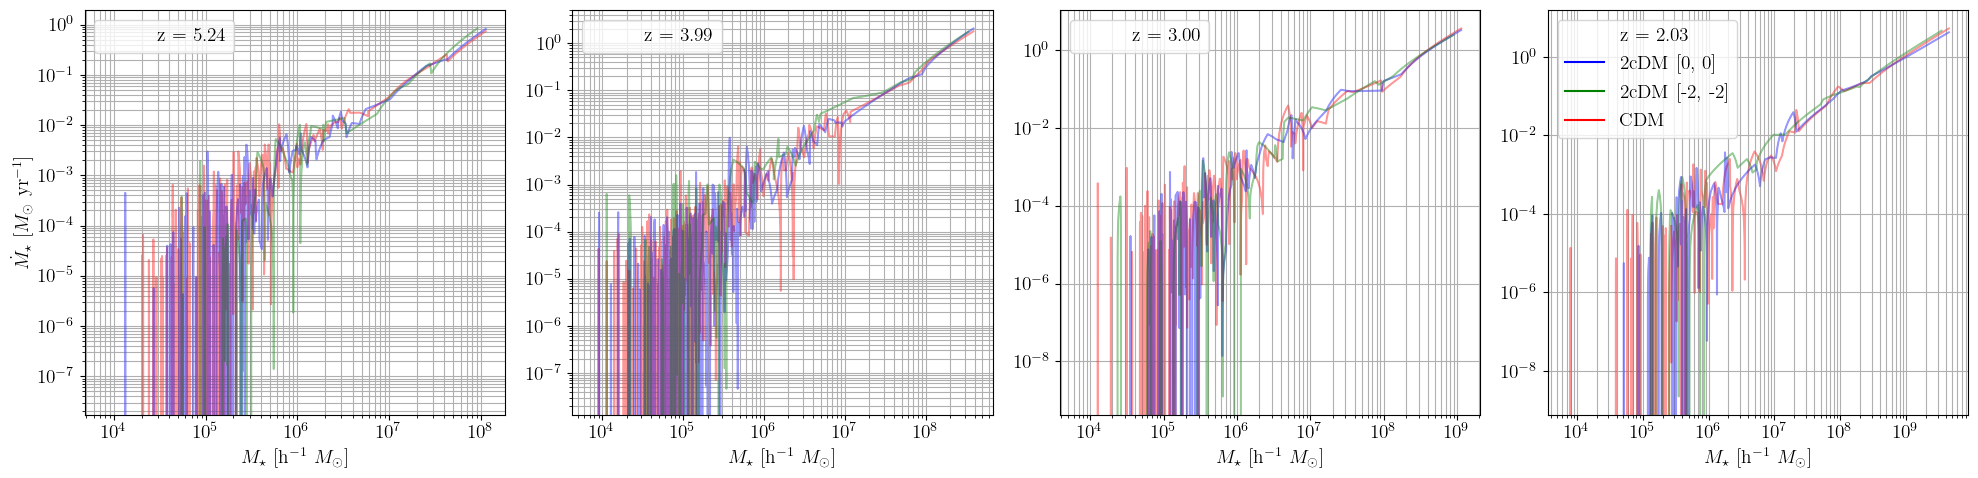

In [5]:
fig, ax = plt.subplots(1, len(snap_range), figsize=FIGSIZE)

for a, redshift in zip(ax, snap_range):

    tcDM_runs = tcDM_runs1

    bins, (CDM_avg, CDM_ten, CDM_ninety), (tcDM_avg, tcDM_ten, tcDM_ninety) = get_averages(CDM_runs, tcDM_runs, redshift, function='SFR')
    a.plot(bins, CDM_avg, alpha=ALPHA, color=cdm_color)
    a.fill_between(bins, CDM_ten, CDM_ninety, alpha=0.5*ALPHA, color=cdm_color)

    a.plot(bins, tcDM_avg, alpha=ALPHA, color=zz_color)
    a.fill_between(bins, tcDM_ten, tcDM_ninety, alpha=0.5*ALPHA, color=zz_color)

    tcDM_runs = tcDM_runs2

    bins, _, (tcDM_avg, tcDM_ten, tcDM_ninety) = get_averages(CDM_runs, tcDM_runs, redshift, function='SFR')
    a.plot(bins, tcDM_avg, alpha=ALPHA, color=m2m2_color)
    a.fill_between(bins, tcDM_ten, tcDM_ninety, alpha=0.5*ALPHA, color=m2m2_color)

    
    r_nearest = cosmoSim(CDM_runs[0], base_path=base_path).get_nearest_redshift(redshift)

    a.set_xlabel('$M_{\\star}$ [h$^{-1}$ $M_{\\odot}$]')

    a.set_yscale("log")
    a.set_xscale("log")
    # a.set_xlim(10**-2, 10**1)
    # a.set_ylim(10**-8, 10**1)
    a.grid(True, which="both", ls="-")
    a.set_aspect( 'auto', adjustable='box' )
    a.plot([],[], label=f'z = {r_nearest:.2f}', alpha=0)
    a.legend()
    
    
ax[0].set_ylabel("$\dot{M_{\\star}}$ [$M_{\odot}$ yr$^{-1}$]")

# a.set_ylim(10**-13, 10**1)

a.plot([],[], label='2cDM [0, 0]', color=zz_color)
a.plot([],[], label='2cDM [-2, -2]', color=m2m2_color)
a.plot([],[], label='CDM', color=cdm_color)
# a.plot([],[], label='Hydro', color='k')
# a.plot([],[], label='N-Body', color='k', linestyle='dashed')
a.legend()

fig.tight_layout()
fname = outpath + f'grid_SFR_vs_stmass'
fname += '_with00'
fname += '_withm2m2'
fname += '.pdf'
# plt.savefig(fname, dpi=DPI, bbox_inches='tight')
plt.show()

<>:57: SyntaxWarning: invalid escape sequence '\d'
<>:57: SyntaxWarning: invalid escape sequence '\d'
/tmp/ipykernel_2438951/3845668282.py:57: SyntaxWarning: invalid escape sequence '\d'
  ax[0].set_ylabel("$\dot{M_{\\star}}$ [$M_{\odot}$ yr$^{-1}$]")
/home/ryan/projects/Medvedev/dm_sims/jupyter/global/paperI/../../../py/cosmoSim.py:118: UserWarning: WARNING: Requested redshift 5 is not within tolerance 0.1 of snapshot redshift 5.236226422509304 in run run_CDM_L3N256_HY_dir_0!
  warnings.warn(f"WARNING: Requested redshift {redshift} is not within tolerance {tolerance} of snapshot redshift {self.redshifts[idx]} in run {self.run_name}!")
/home/ryan/projects/Medvedev/dm_sims/jupyter/global/paperI/../../../py/cosmoSim.py:118: UserWarning: WARNING: Requested redshift 5 is not within tolerance 0.1 of snapshot redshift 5.236226422509304 in run run_CDM_L3N256_HY_dir_1!
  warnings.warn(f"WARNING: Requested redshift {redshift} is not within tolerance {tolerance} of snapshot redshift {self.redshi

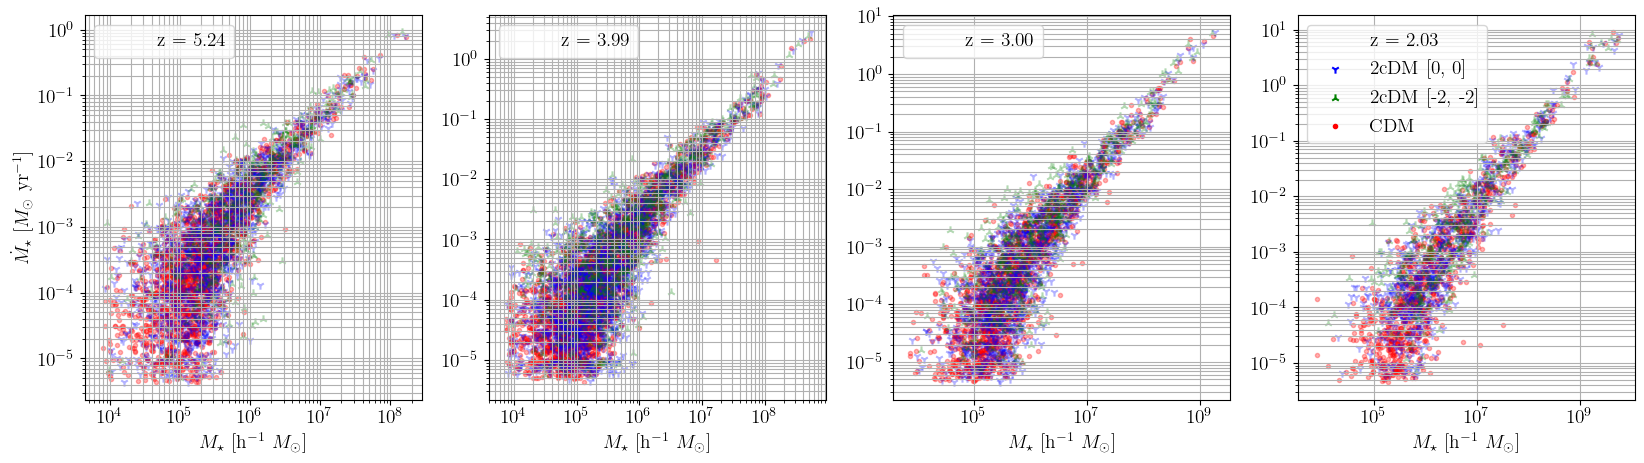

In [6]:
fig, ax = plt.subplots(1, len(snap_range), figsize=FIGSIZE)

for a, redshift in zip(ax, snap_range):

    tcDM_runs = tcDM_runs1
    
    for run_n in CDM_runs:
    
        run = cosmoSim(run_n, base_path=base_path)
        idx = run.redshift_to_index(redshift)

        fof = os.path.join(data_dir, run_n, f'fof_subhalo_tab_{idx:03}.hdf5')
        with h5py.File(fof, 'r') as f:
            hmass = f['Subhalo/SubhaloMassType'][()][:,4] * 10**10
            nonzero = hmass[ hmass != 0 ]
            SFR = f['Subhalo/SubhaloSFR'][()][ hmass != 0 ]
        a.scatter(nonzero, SFR, alpha=ALPHA, color=cdm_color, marker='.')

    for run_n in tcDM_runs1:
    
        run = cosmoSim(run_n, base_path=base_path)
        idx = run.redshift_to_index(redshift)

        fof = os.path.join(data_dir, run_n, f'fof_subhalo_tab_{idx:03}.hdf5')
        with h5py.File(fof, 'r') as f:
            hmass = f['Subhalo/SubhaloMassType'][()][:,4] * 10**10
            nonzero = hmass[ hmass != 0 ]
            SFR = f['Subhalo/SubhaloSFR'][()][ hmass != 0 ]
        a.scatter(nonzero, SFR, alpha=ALPHA, color=zz_color, marker='1')

    for run_n in tcDM_runs2:
    
        run = cosmoSim(run_n, base_path=base_path)
        idx = run.redshift_to_index(redshift)

        fof = os.path.join(data_dir, run_n, f'fof_subhalo_tab_{idx:03}.hdf5')
        with h5py.File(fof, 'r') as f:
            hmass = f['Subhalo/SubhaloMassType'][()][:,4] * 10**10
            nonzero = hmass[ hmass != 0 ]
            SFR = f['Subhalo/SubhaloSFR'][()][ hmass != 0 ]
        a.scatter(nonzero, SFR, alpha=ALPHA, color=m2m2_color, marker='2')   

    
    r_nearest = cosmoSim(CDM_runs[0], base_path=base_path).get_nearest_redshift(redshift)

    a.set_xlabel('$M_{\\star}$ [h$^{-1}$ $M_{\\odot}$]')
    a.set_yscale("log")
    a.set_xscale("log")
    # a.set_xlim(10**-2, 10**1)
    # a.set_ylim(10**-8, 10**1)
    a.grid(True, which="both", ls="-")
    a.set_aspect( 'auto', adjustable='box' )
    a.plot([],[], label=f'z = {r_nearest:.2f}', alpha=0)
    a.legend()
    
    
ax[0].set_ylabel("$\dot{M_{\\star}}$ [$M_{\odot}$ yr$^{-1}$]")


a.scatter([],[], label='2cDM [0, 0]', color=zz_color, marker='1')
a.scatter([],[], label='2cDM [-2, -2]', color=m2m2_color, marker='2')
a.scatter([],[], label='CDM', color=cdm_color, marker='.')

a.legend()
